# Build Simple Valuation Model and Evaluate on Test Data

In this notebook:
- Preliminaries (importing packages, setting options)
- Preprocess data ready for use by LightGBM.  Includes:
    - splitting into training and testing samples
    - dropping columns which contain information not available at time or valuation (to avoid target leakage)
    - convert columns which are categorical to pandas Category data type (this is checked by LightGBM)
- Tune hyperparameters using FLAML, using training data
- Assess performance in testing sample.  Overall mean absolute error is quite high - 54 vs average of 177 (30%).  Performance worse for heretidmetns with small rateable values.
- Looking at the feature importances:
    - Location (Billing Authority) and purpose (SCAT) are very important, which makes sense
    - TotalArea is important, indicating that rateable value per unit area varies between larger and smaller areas.
    - Interesting that OtherFloors, which represents the area of floors that are **not** ground, first or second floors, is important.  As we know from the visualisations this is picking-up tall buildings where are concentrated in cities and especially in the City of London
    - Offices, internal storage and car parking spaces are also important
    - Sadly, having a bar is not important
- The final model is saved and:
    - Is exposed via an API: https://github.com/pasbury/voa-model-api
    - Which is used to power this calculator UI: https://voa-ui-app.herokuapp.com/
    
- Future work (!):
    - Consider weighting by TotalArea
    - Use SHAP values to further explore feature importance and fine tune model

LightGBM documentation [here](https://lightgbm.readthedocs.io/en/latest/index.html)



## Preliminaries

In [111]:
import pandas as pd
import numpy as np
import re
import geopandas as gpd
import json
import plotly.express as px
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import gc
import shap

In [112]:
from tqdm.notebook import tqdm
import pickle

In [113]:
from flaml import AutoML
from flaml.data import get_output_from_log

In [114]:
shap.initjs()

In [115]:
%matplotlib inline

In [116]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [117]:
shapefilepath = 'GB_Postcodes/GB_Postcodes/PostalArea.shp'

In [118]:
mod = pickle.load(open('mod.p','rb'))

In [119]:
mod.rename(columns={'Store ':'Store_03'}, inplace=True)
mod = mod[(mod['Adopted RV'] > 1) & (mod['Total Area'] > 1)]
mod = mod.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
mod['RVPerUnitArea'] = np.where(mod['TotalArea']>0,mod['AdoptedRV']/mod['TotalArea'],np.nan)

In [120]:
# Check full any nulls
#mod.isna().sum()

In [121]:
area_cols = ['GroundFirstOrSecond',
       'OtherFloor', 'AllMainAreas', 'AreaUnderSupportedFloor', 'Bar',
       'Canteen', 'ChillStore', 'Classroom', 'ColdStore', 'ComputerRoom',
       'ExternalStorage', 'Garage', 'GolfCourse', 'GroundFloorSales', 'Hall',
       'HardSurfacedFencedLand_02', 'InternalStorage', 'Kitchen', 'Laboratory',
       'Lounge', 'MessStaffRoom', 'Nursery', 'Office_02', 'OtherDescription',
       'ParkingSpaceS', 'ProductionArea', 'ReceptionEntrance',
       'RemainingRetailZone', 'Restaurant', 'RetailArea', 'RetailZoneA',
       'RetailZoneB', 'RetailZoneC', 'RoughSurfacedFencedLand_02', 'Showroom',
       'SingleBedSpace', 'Store', 'Surgery', 'TotalFloorAreaDryLeisureClubs',
       'UnsurfacedFencedLand_02', 'Warehouse', 'WorksOffice', 'Workshop_02',
       'AirConditioningSystem', 'FirstFloorSales', 'HardSurfacedFencedLand_03',
       'HardSurfacedUnfencedLand', 'IndoorArena', 'MezzanineFloor',
       'MiscellaneousAddition', 'Office_03', 'OtherOADescription',
       'OutdoorArena', 'PetrolForecourtandShop', 'PortableBuilding',
       'RoughSurfacedFencedLand_03', 'StorageContainer', 'Store_03',
       'SupportedStorageFloor', 'UnsurfacedFencedLand_03',
       'UnsurfacedUnfencedLand', 'VehicleDisplaySpaces', 'VehicleSpaces',
       'Workshop_03']

In [122]:
def divide_by_total_area(cols):
    total_area = cols[0]
    cols = cols[1:]
    return tuple([c/total_area if total_area > 0 else np.nan for c in cols])

In [123]:
new_cols = mod[['TotalArea']+area_cols].apply(lambda x: divide_by_total_area(x), axis=1, result_type='expand')
new_col_names = [ col_name + 'Pct' for col_name in area_cols ]
mod[new_col_names] = new_cols
mod.drop(columns = area_cols, inplace=True)

In [124]:
unit_lookup = {'NIA':1, 'GIA':2, 'OTH':3, 'GEA':4, 'EFA':5, 'RCA':6}
mod['UnitofMeasurement_Int'] = mod['UnitofMeasurement'].map(unit_lookup)
mod['BillingAuthorityCode'] = mod['BillingAuthorityCode'].astype(str).astype(int)
mod['SCATCodeOnly'] = mod['SCATCodeOnly'].astype(str).astype(int)

In [125]:
# Create labels and features

In [126]:
y = mod['RVPerUnitArea']
X = mod.drop(['RVPerUnitArea','AdoptedRV','FirmsName','UnadjustedPrice','TotalValue','SubTotal','Postcode','SchemeReference','Town','County','PostalDistrict', 'PostalArea','PrimaryDescriptionText','UnitofMeasurement'], axis=1)

In [127]:
# Convert int to cetegory for LGBM with FLAML
X[X.select_dtypes(['int32', 'int64']).columns] = X[X.select_dtypes(['int32', 'int64']).columns].astype('category')

In [350]:
# Split data into training, validation and testing

In [351]:
len(X)

1875663

In [352]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=44)

In [353]:
print('The average Adopted RVs per unit area in the two datasets are: Train ' + str(int(np.mean(y))) + ' Test ' + str(int(np.mean(y_test))))

The average Adopted RVs per unit area in the two datasets are: Train 179 Test 177


## Use Microsoft's LightGBM to Train an ensemble of regression trees

### First use FLAML to find optimised hyperparmeters using training data

In [354]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 500,  # in seconds
    "metric": 'mae',
    "task": 'regression',
    "estimator_list": ['lgbm'], 
    "log_file_name": "flaml_logs/voa_light_gbm_regression.log",
#    "categorical_feature":"0,1,67"
}
# Train with labeled input data
automl.fit(X_train=X, y_train=y, **automl_settings)

[flaml.automl: 05-24 16:25:13] {890} INFO - Evaluation method: holdout
[flaml.automl: 05-24 16:25:21] {606} INFO - Using RepeatedKFold
[flaml.automl: 05-24 16:25:21] {911} INFO - Minimizing error metric: mae
[flaml.automl: 05-24 16:25:21] {930} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 05-24 16:25:21] {994} INFO - iteration 0, current learner lgbm
[flaml.automl: 05-24 16:25:23] {1147} INFO -  at 107.1s,	best lgbm's error=167.0597,	best lgbm's error=167.0597
[flaml.automl: 05-24 16:25:23] {994} INFO - iteration 1, current learner lgbm
[flaml.automl: 05-24 16:25:24] {1147} INFO -  at 107.6s,	best lgbm's error=167.0597,	best lgbm's error=167.0597
[flaml.automl: 05-24 16:25:24] {994} INFO - iteration 2, current learner lgbm
[flaml.automl: 05-24 16:25:24] {1147} INFO -  at 108.1s,	best lgbm's error=167.0597,	best lgbm's error=167.0597
[flaml.automl: 05-24 16:25:24] {994} INFO - iteration 3, current learner lgbm
[flaml.automl: 05-24 16:25:25] {1147} INFO -  at 108.6s,

### Second, assess model performance on (unseen) test data

In [355]:
print('Starting predicting...')
# predict
y_pred = automl.predict(X_test)
# eval
print('The rmse of prediction is:', int(mean_squared_error(y_test, y_pred) ** 0.5))
print('The mae of prediction is:', int(mean_absolute_error(y_test, y_pred)))

Starting predicting...
The rmse of prediction is: 376
The mae of prediction is: 54


In [357]:
# Profile predictions and accuracy
features = X_test.columns
print(features)
X_test = X_test.join(mod[['AdoptedRV', 'PostalArea']],how='left')
X_test['PredictedRV'] = np.where(y_pred > 0, y_pred * X_test['TotalArea'], 0)
#X_test['Adopted RV'] = y_test
X_test['Absolute error'] = abs(X_test['PredictedRV'] - X_test['AdoptedRV'])
X_test['Absolute percent error'] = X_test['Absolute error'] / X_test['AdoptedRV']

Index(['BillingAuthorityCode', 'TotalArea', 'SCATCodeOnly', 'CPSpaces',
       'GroundFirstOrSecondPct', 'OtherFloorPct', 'AllMainAreasPct',
       'AreaUnderSupportedFloorPct', 'BarPct', 'CanteenPct', 'ChillStorePct',
       'ClassroomPct', 'ColdStorePct', 'ComputerRoomPct', 'ExternalStoragePct',
       'GaragePct', 'GolfCoursePct', 'GroundFloorSalesPct', 'HallPct',
       'HardSurfacedFencedLand_02Pct', 'InternalStoragePct', 'KitchenPct',
       'LaboratoryPct', 'LoungePct', 'MessStaffRoomPct', 'NurseryPct',
       'Office_02Pct', 'OtherDescriptionPct', 'ParkingSpaceSPct',
       'ProductionAreaPct', 'ReceptionEntrancePct', 'RemainingRetailZonePct',
       'RestaurantPct', 'RetailAreaPct', 'RetailZoneAPct', 'RetailZoneBPct',
       'RetailZoneCPct', 'RoughSurfacedFencedLand_02Pct', 'ShowroomPct',
       'SingleBedSpacePct', 'StorePct', 'SurgeryPct',
       'TotalFloorAreaDryLeisureClubsPct', 'UnsurfacedFencedLand_02Pct',
       'WarehousePct', 'WorksOfficePct', 'Workshop_02Pct',
    

In [358]:
# MAPE by adopted RV

In [359]:
X_test['Vintiles of Adopted RV'] = pd.qcut(X_test['AdoptedRV'],20)

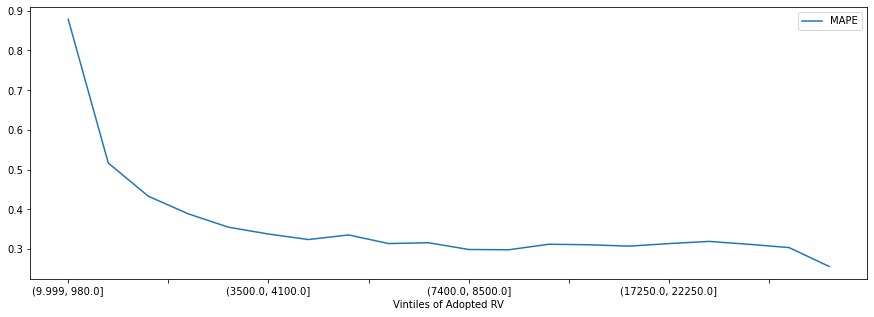

In [360]:
z = X_test[['Absolute error','AdoptedRV','Vintiles of Adopted RV']].groupby('Vintiles of Adopted RV').sum()
z['MAPE'] = z['Absolute error']/z['AdoptedRV']
z.plot(y='MAPE',figsize=(15,5))

In [361]:
# So poor accuracy for properties with low rateable vlaues

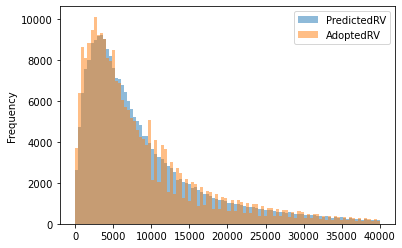

In [362]:
X_test[['PredictedRV', 'AdoptedRV']][(X_test['AdoptedRV']<40000) & (X_test['PredictedRV']<40000)&(X_test['PredictedRV']>0)].plot.hist(bins=100, alpha=0.5)

In [363]:
# MAPE by Postal Area

In [364]:
pa = gpd.read_file(shapefilepath)

In [365]:
X_pa = X_test[['PostalArea','Absolute error','AdoptedRV']].reset_index().groupby('PostalArea').sum().reset_index()
X_pa = pa.merge(X_pa, right_on='PostalArea', left_on='PostArea', how='inner')
X_pa['MAPE'] = X_pa['Absolute error']/X_pa['AdoptedRV']

In [366]:
def postalareaplot(metric):
    f, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,7))
    f.suptitle('Total ' + metric + ' by Postal Area', fontsize=16)
    X_pa.plot(ax=ax1, column=metric, legend=True)
    ax1.set(title='England and Wales')
    ax1.tick_params(labelbottom=False, labelleft=False)
    X_pa[X_pa['Sprawl']=='London'].plot(ax=ax2,column=metric, legend=True)
    ax2.set(title='London')
    ax2.tick_params(labelbottom=False, labelleft=False)

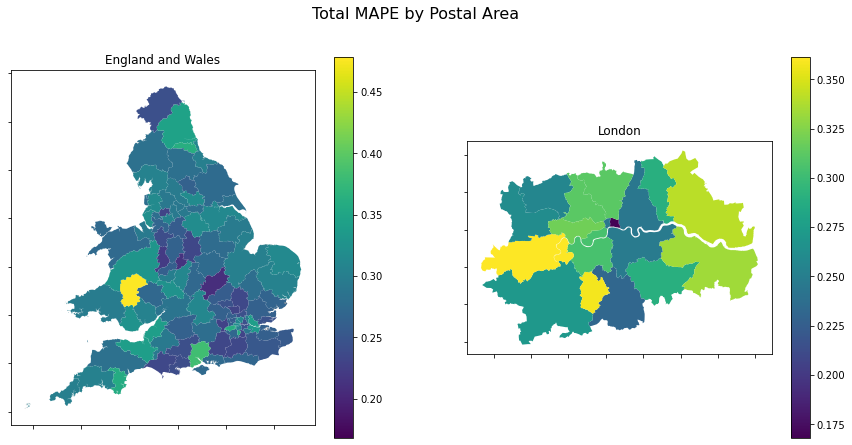

In [367]:
postalareaplot('MAPE')

## Train model on full dataset, ready for use

In [368]:
# Rebuid complete dataset for final training
#features = X_test.columns
X_full = pd.concat([X, X_test[features]])
y_full = np.concatenate([y.to_numpy(), y_test.to_numpy()])
print('Check rows in X_full and y_full: ' + str(len(X_full)) + ', ' + str(len(y_full)))
full_data = lgb.Dataset(X_full, label=y_full, free_raw_data=False)
X_full = None
gc.collect()

Check rows in X_full and y_full: 1875663, 1875663


12573

In [369]:
# Format parameters correctly for LighGBM
def prep_params(config):
    # Check if in the "bad" format
    if 'FLAML_sample_size' in config:
        # convert to integer
        for p in ['n_estimators', 'num_leaves', 'min_child_samples']:
            config[p] = int(config[p])
        # calc max_bin from log_max_bin
        config['max_bin'] = int(2**config['log_max_bin'])
        # remove unecessary params that cause warnings
        for p in ['FLAML_sample_size', 'log_max_bin']:
            config.pop(p, None)
 
    return config

In [370]:
best_params = prep_params(automl.best_config)

In [371]:
# train on full dataset with optimised hyper parameters
print('Starting training...')
gbm = lgb.train(best_params, full_data)

Starting training...


Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13975
[LightGBM] [Info] Number of data points in the train set: 1875663, number of used features: 68
[LightGBM] [Info] Start training from score 178.998905


In [372]:
print('Starting predicting...')
# predict
y_full_pred = gbm.predict(full_data.get_data(), num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', int(mean_squared_error(y_full, y_full_pred) ** 0.5))
print('The mae of prediction is:', int(mean_absolute_error(y_full, y_full_pred)))

Starting predicting...
The rmse of prediction is: 582
The mae of prediction is: 53


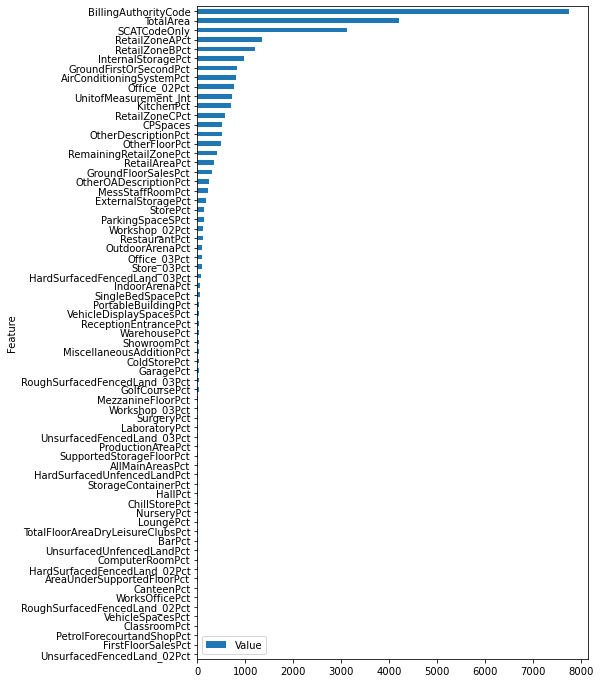

In [373]:
# Get feature importance
gbmimportance = pd.DataFrame({'Value':gbm.feature_importance(),'Feature':full_data.get_data().columns.tolist()}).sort_values(by="Value")
gbmimportance.plot.barh(x='Feature', figsize=(7,12))

In [383]:
# Save model
print('Saving model...')
# save model to file
gbm.save_model('models/model.txt')

Saving model...
